# GKO Synthetic Experiment

In this experiment, we are testing the performance of following methods: GK, GKO, and MWRKO. Iteration and CPU are measured for different types of system including the following:

* System with two set of correlated systems

In [5]:
# Load libraries
import pandas as pd
import numpy as np
from time import process_time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import math
from numpy.random import default_rng
from sklearn.preprocessing import normalize

In [6]:
# importing algorithm functions
import sys
sys.path.insert(1, '/Users/jennytran/Documents/GitHub/gko-23/scripts/functions')
from method import method

In [56]:
def method2(A, x, y, case, TOL):
    k=1
    m, n = A.shape
    x_old = np.zeros(n)
    ap_error = []
    ar = (np.linalg.norm(y-A@x_old))**2 / np.linalg.norm(y)**2
    ap_error.append(ar)
    A_lst = []
    
    if case == 'GKO' or case == 'MWRKO':
        inner_p = A@np.transpose(A)
        row_lst = [] 
        resid = abs(A@x_old - y)
        denom = np.sum(np.abs(A)**2,axis=-1)**(1./2)
        i1 = np.argmax(resid/denom)
        a1 = A[i1,:]
        A_lst.append(A[i1,:])
        x1 = x_old - ((a1@x_old - y[i1]) / np.linalg.norm(a1)**2) * np.transpose(a1)
        x_old = x1
        row_lst.append(i1)
        ar = (np.linalg.norm(y-A@x_old))**2 / np.linalg.norm(y)**2
        ap_error.append(ar)
        k += 1
        ik = row_lst[-1]
    
    while True:
        rhat = A@x_old - y
        match case:
            case "GK":
                r = (rhat)**2
                i_k1 = np.argmax(r)
                ai = A[i_k1,:]
                xk = x_old - ((np.transpose(ai)@x_old - y[i_k1]) /  np.linalg.norm(ai)**2 * ai)
            case "GKO":
                inner_dig = np.delete(inner_p.diagonal(), ik)
                all_comb = np.delete(inner_p[:,ik], ik)
                denom = inner_dig - np.square(all_comb) / np.linalg.norm(A[ik,:])**2
                resid  = np.delete(abs(rhat), ik)
                i_k1 = np.argmax(resid/np.sqrt(denom))
                if (i_k1 >= ik):
                  i_k1 += 1
                row_lst.append(i_k1)
                r = A[i_k1,:]@x_old - y[i_k1]
                w = A[i_k1,:] - ((inner_p[ik, i_k1] / np.linalg.norm( A[ik,:])**2) * A[ik,:])
                t = r / np.linalg.norm(w)**2
                xk = x_old - t*w
            case "MWRKO":
                resid = abs(rhat)
                i_k1 = np.argmax(resid/denom)
                row_lst.append(i_k1)
                r = A[i_k1,:]@x_old - y[i_k1]
                w = A[i_k1,:] - ((inner_p[ik, i_k1] / np.linalg.norm( A[ik,:])**2) * A[ik,:])
                t = r / np.linalg.norm(w)**2
                xk = x_old - t*w      
        A_lst.append(A[i_k1,:])
        x_old = xk
        ar = (np.linalg.norm(y-A@x_old))**2 / np.linalg.norm(y)**2
        ap_error.append(ar)
        k+=1
        
        if ar < TOL or k == 100000:
            break
            
    return k, ap_error, A_lst

### Generate System

In [67]:
# Generate system
# Step 1: generate two gaussian linear system
A = np.random.randn(2,500)
A1 = np.reshape(A[0,:], (1, 500))
A2 = np.reshape(A[1,:], (1, 500))

In [68]:
# Step 2: generate correalted systems
U = np.random.rand(2500, 500)
#np.random.uniform(low = 0, high = 1, size  = (2500,500))
A1 =  np.tile(A1, (2500, 1)) +  U
A2 =  np.tile(A2, (2500, 1)) +  U

In [69]:
# Step 3: Combine two correlated systems
A = np.concatenate((A1, A2))
x = np.ones(500)
y = A @ x

### Run Experiments

In [70]:
# gk
gk_start_cyclic_corr = process_time()
gk_corr = method2(A,x,y,'GK', 0.5*10**-8)
gk_stop_cyclic_corr = process_time()
# gko
gko_start_cyclic_corr = process_time()
gko_corr = method2(A,x,y,'GKO', 0.5*10**-8)
gko_stop_cyclic_corr = process_time()
# mwrko
mwrko_start_cyclic_corr = process_time()
mwrko_corr = method2(A,x,y,'MWRKO', 0.5*10**-8)
mwrko_stop_cyclic_corr = process_time()

In [71]:
gk_proj = []
gko_proj = []
mwrko_proj = []
for n in gk_corr[-1]:
    if n in A1:
        gk_proj.append('A1')
    elif n in A2:
        gk_proj.append('A2')

for n in gko_corr[-1]:
    if n in A1:
        gko_proj.append('A1')
    elif n in A2:
        gko_proj.append('A2')

for n in mwrko_corr[-1]:
    if n in A1:
        mwrko_proj.append('A1')
    elif n in A2:
        mwrko_proj.append('A2')

In [72]:
df_proj = pd.DataFrame()
df_proj['method'] = ['GK', 'GKO', 'MWRKO']
df_proj['IT'] = [gk_corr[0], gko_corr[0], mwrko_corr[0]]
df_proj['A1'] = [gk_proj.count('A1'), gko_proj.count('A1'), mwrko_proj.count('A1')]
df_proj['A2'] = [gk_proj.count('A2'), gko_proj.count('A2'), mwrko_proj.count('A2')]
df_proj

,method,IT,A1,A2
0,GK,15977,2324,13652
1,GKO,1887,1884,2
2,MWRKO,16190,1,16188


In [73]:
df_proj = pd.DataFrame()
#df_proj['method'] = ['GK', 'GKO', 'MWRKO']
#df_proj['IT'] = [gk_corr[0], gko_corr[0], mwrko_corr[0]]
df_proj['GK'] = gk_proj[:50] 
df_proj['GKO'] = gko_proj[:50]
df_proj['MWRKO'] = mwrko_proj[:50]
df_proj

,GK,GKO,MWRKO
0,A1,A1,A1
1,A2,A2,A2
2,A1,A1,A2
3,A1,A1,A2
4,A1,A1,A2
5,A1,A1,A2
6,A1,A1,A2
7,A1,A1,A2
8,A1,A1,A2
9,A1,A1,A2


In [37]:
# cpu data
gk_cpu_corr = gk_stop_cyclic_corr - gk_start_cyclic_corr
gko_cpu_corr = gko_stop_cyclic_corr - gko_start_cyclic_corr
mwrko_cpu_corr = mwrko_stop_cyclic_corr - mwrko_start_cyclic_corr

print(gk_cpu_corr, gko_cpu_corr, mwrko_cpu_corr)

72.34651700000006 14.106144000000086 76.90507200000002


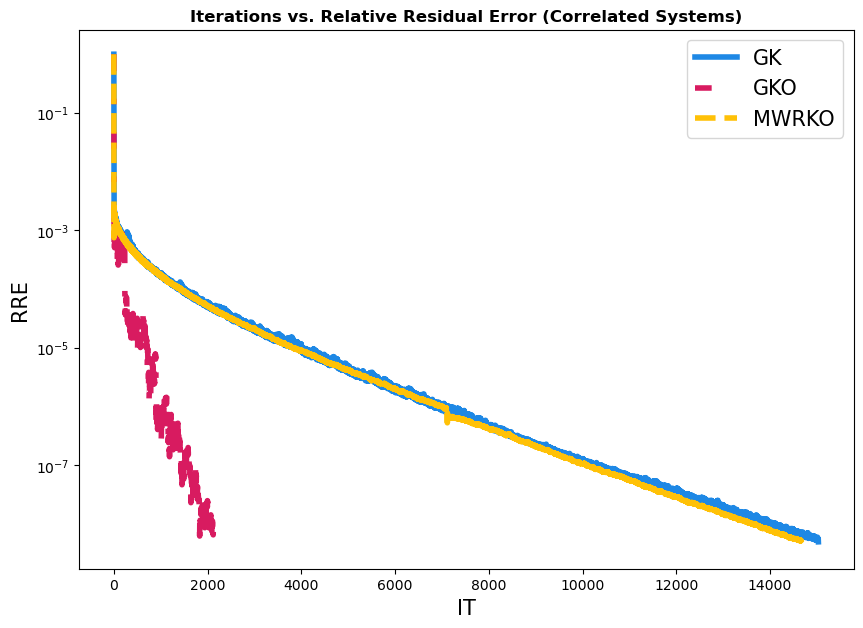

<Figure size 640x480 with 0 Axes>

In [38]:
plt.figure(figsize=(10,7))

plt.semilogy(np.arange(gk_corr[0]), gk_corr[1], 
             color = '#1E88E5', linewidth = 4, linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_corr[0]), gko_corr[1],
            color = '#D81B60', linewidth = 4, linestyle = (0, (3, 5, 1, 5)), label = 'GKO')
plt.semilogy(np.arange(mwrko_corr[0]), mwrko_corr[1],
            color = '#FFC107', linewidth = 4, linestyle = 'dashed', label = 'MWRKO')

plt.xlabel('IT', fontsize = 15)
plt.ylabel('RRE', fontsize = 15)
plt.title('Iterations vs. Relative Residual Error (Correlated Systems)', fontweight="bold")
plt.legend(fontsize="15")
plt.show()
plt.savefig('../../outputs/synthetic-exp/5000x500/iter/5000-corr-iter.png')

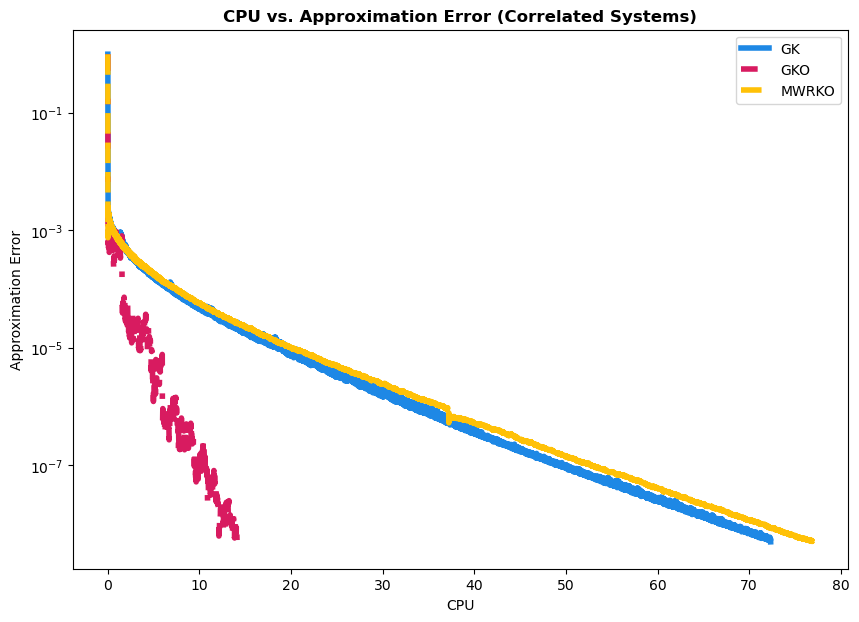

In [39]:
plt.figure(figsize=(10,7))

plt.semilogy(np.linspace(0,gk_cpu_corr,gk_corr[0]), gk_corr[1],
            color = '#1E88E5', linewidth = 4, linestyle = 'solid', label = 'GK')
plt.semilogy(np.linspace(0,gko_cpu_corr,gko_corr[0]), gko_corr[1],
            color = '#D81B60', linewidth = 4, linestyle = (0, (3, 5, 1, 5)), label = 'GKO')
plt.semilogy(np.linspace(0,mwrko_cpu_corr,mwrko_corr[0]), mwrko_corr[1],
            color = '#FFC107', linewidth = 4, linestyle = 'dashed', label = 'MWRKO')

plt.xlabel('CPU')
plt.ylabel('Approximation Error')
plt.title('CPU vs. Approximation Error (Correlated Systems)',  fontweight="bold")
plt.legend(fontsize="15")
plt.legend()
plt.savefig('../../outputs/synthetic-exp/5000x500/iter/5000-corr-cpu.png')

## Experiment 2: Testing Different Correlated Systems

We will test the performance of our methods using different lowerbounds c, which determines how correlated systems are.

In [55]:
c = [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 ]
gk_iter = []
gko_iter = []
mwrko_iter = []
gk_cpulst = []
gko_cpulst = []
mwrko_cpulst = []

for bd in c:
    print(bd)
    # Generate system
    # Step 1: generate two gaussian linear system
    A = np.random.randn(2,500)
    A1 = np.reshape(A[0,:], (1, 500))
    A2 = np.reshape(A[1,:], (1, 500))
    # Step 2: generate correalted systems
    U = np.random.uniform(low = -bd, high = bd, size  = (2500,500))
    A1 = np.tile(A1, (2500, 1)) + U
    A2 = np.tile(A2, (2500, 1)) + U
    # Step 3: Combine two correlated systems
    A = np.concatenate((A1, A2))
    x = np.ones(500)
    y = A @ x
    
    # Run algorithms
    # gk
    gk_start_cyclic = process_time()
    gk_corr = method(A,x,y,'GK', 0.5*10**(-8))
    gk_stop_cyclic = process_time()
    # gko
    gko_start_cyclic = process_time()
    gko_corr = method(A,x,y,'GKO', 0.5*10**(-8))
    gko_stop_cyclic = process_time()
    # mwrko
    mwrko_start_cyclic = process_time()
    mwrko_corr = method(A,x,y,'MWRKO', 0.5*10**(-8))
    mwrko_stop_cyclic = process_time()
    
    # cpu data
    gk_cpu = gk_stop_cyclic - gk_start_cyclic
    gko_cpu = gko_stop_cyclic - gko_start_cyclic
    mwrko_cpu = mwrko_stop_cyclic - mwrko_start_cyclic
    
    #append
    gk_iter.append(gk_corr[0])
    gko_iter.append(gko_corr[0])
    mwrko_iter.append(mwrko_corr[0])
    gk_cpulst.append(gk_cpu)
    gko_cpulst.append(gko_cpu)
    mwrko_cpulst.append(mwrko_cpu)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [56]:
df_iter = pd.DataFrame()
df_iter['c'] = c
df_iter['GK'] = gk_iter
df_iter['GKO'] = gko_iter
df_iter['MWRKO'] = mwrko_iter
df_iter

,c,GK,GKO,MWRKO
0,0.1,100000,2086,100000
1,0.2,85924,2788,82949
2,0.3,43992,2562,43511
3,0.4,26697,2849,26176
4,0.5,21363,3468,20848
5,0.6,14303,3106,14725
6,0.7,12330,3173,12644
7,0.8,9861,3103,9754
8,0.9,7857,2898,7897
9,1.0,7302,3220,7031


In [57]:
df_cpu = pd.DataFrame()
df_cpu['c'] = c
df_cpu['GK'] = gk_cpulst
df_cpu['GKO'] = gko_cpulst
df_cpu['MWRKO'] = mwrko_cpulst
df_cpu

,c,GK,GKO,MWRKO
0,0.1,494.642674,11.560529,437.975313
1,0.2,360.742146,17.069054,352.022119
2,0.3,182.758137,16.710186,200.131663
3,0.4,109.157384,14.749269,108.628413
4,0.5,84.673253,17.485862,88.283607
5,0.6,60.819640,15.796360,61.972109
6,0.7,53.097616,16.119026,51.542727
7,0.8,39.227657,19.353491,39.567183
8,0.9,31.204441,15.155079,36.555831
9,1.0,28.454522,16.812102,28.685023
